In [16]:
import matplotlib.pyplot as plt
#importing
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from timeit import default_timer

Let's handle the datasets

In [17]:
training_data = datasets.FashionMNIST(root="data_cnn",
                                      train=True,
                                      transform=ToTensor(),
                                      download=True)

test_data = datasets.FashionMNIST(root="data_cnn",
                                  train=False,
                                  transform=ToTensor(),
                                  download=True)

> let's visualize the datasets

In [18]:
classes = training_data.classes

In [19]:
def visualize_datasets():
    rows, cols = 5, 5
    plt.figure(figsize=(10, 10))
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        img, y = training_data[i]
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(classes[y])
        plt.axis(False)


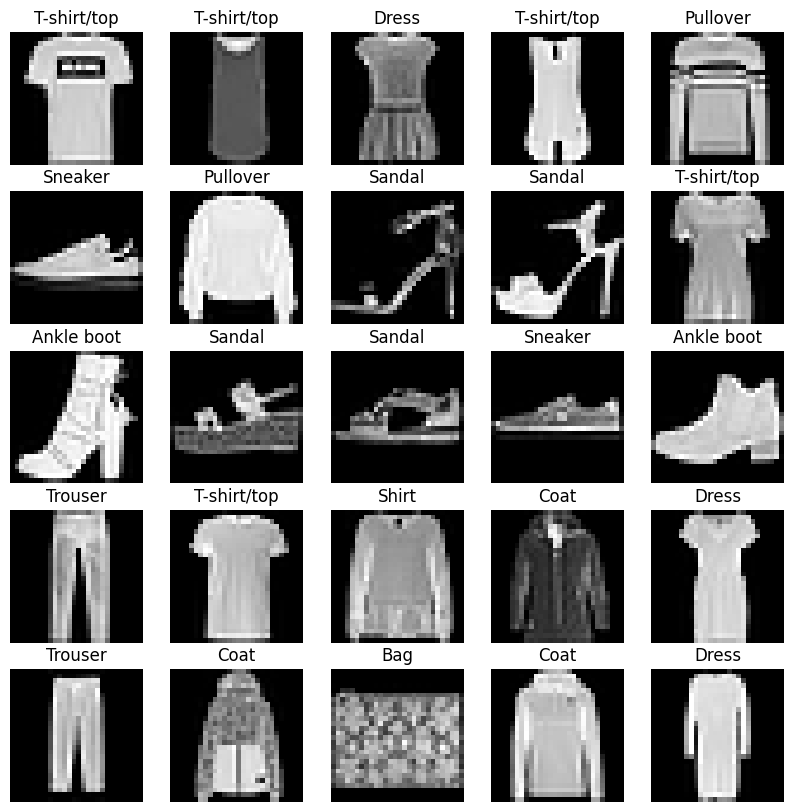

In [20]:
visualize_datasets()

#### agnostic code for targeting device

In [21]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu")
print(f"Processor Device Name: [{device}]")

Processor Device Name: [mps]


In [22]:
BatchSize = 32
training_data_loader = DataLoader(dataset=training_data,
                                  batch_size=BatchSize,
                                  shuffle=True)

testing_data_loader = DataLoader(dataset=test_data,
                                 shuffle=True)

len(training_data_loader), len(testing_data_loader)

(1875, 10000)

#### Now it's time to build model architecture

In [23]:
class TinyVggCnnModelV1(nn.Module):
    def __init__(self, input_, hidden_, output_):
        super().__init__()
        self.cnn_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_,
                      out_channels=hidden_,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_,
                      out_channels=hidden_,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.cnn_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_, out_channels=hidden_, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_, out_channels=hidden_, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(hidden_ * 7 * 7), out_features=output_)
        )

    def forward(self, x):
        x = self.cnn_block1(x)
        # print(x.shape)
        x = self.cnn_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [24]:
model_cnn0 = TinyVggCnnModelV1(input_=1, hidden_=10, output_=len(classes))
print(f"Model Details: {model_cnn0.state_dict()}")

Model Details: OrderedDict({'cnn_block1.0.weight': tensor([[[[ 0.3104, -0.2038, -0.3312],
          [-0.3175, -0.2138,  0.1252],
          [ 0.1642, -0.2663,  0.0797]]],


        [[[-0.2899, -0.0052, -0.1031],
          [ 0.2304, -0.2508,  0.2301],
          [ 0.2661, -0.1906, -0.1417]]],


        [[[ 0.0097,  0.0822, -0.0114],
          [-0.1459,  0.2241, -0.2944],
          [-0.0651,  0.1090, -0.2052]]],


        [[[-0.1896,  0.2124,  0.2370],
          [-0.0360,  0.1596,  0.1572],
          [-0.0172, -0.1867, -0.0473]]],


        [[[-0.1924, -0.2660,  0.0945],
          [-0.0333,  0.3250, -0.1560],
          [ 0.2263,  0.0578, -0.2136]]],


        [[[-0.2546, -0.0360, -0.0480],
          [ 0.0770,  0.2486, -0.2258],
          [ 0.1857, -0.2701,  0.2568]]],


        [[[ 0.3182,  0.1779, -0.0087],
          [ 0.3013,  0.1979,  0.3090],
          [ 0.0990,  0.1561,  0.3239]]],


        [[[-0.3328,  0.3265, -0.0023],
          [-0.1431,  0.0152,  0.0879],
          [-0.2352,  0.2

## Now we need to define Loss Function, Optimizer, Accuracy Function

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn0.parameters(), lr=0.05)
loss_fn, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.05
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [26]:
def accuracy_fn(true_preds, y_preds):
    correct = torch.eq(true_preds, y_preds).sum()
    return correct / len(true_preds) * 100

Define Timing Step

In [27]:
def CalcTime(start, end):
    return end - start

### Defining Training Step

In [28]:
def training_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  accuracy_fn,
                  optimizer: torch.optim.SGD,
                  device=device):

    start_time = default_timer()
    # first of all, we need to put the model in training mode
    model.train()
    # put the model to the device
    model.to(device)

    training_loss, training_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        ylogits = model(X)
        ypreds = ylogits.argmax(dim=1)

        loss = loss_fn(ylogits, y)

        training_loss += loss.item()
        training_acc += accuracy_fn(true_preds=y, y_preds=ypreds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    training_loss /= len(data_loader)
    training_acc /= len(data_loader)
    print(f"Training Loss: {training_loss:.3f}, Training Acc: {training_acc:.3f}%")

    end_time = default_timer()
    print(f"Training Time: {CalcTime(start=start_time, end=end_time):.3f} sec on device {device}")


In [40]:
def eval_model(model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              dataloader: torch.utils.data.DataLoader,
              device=device):
    model.eval()
    model.to(device)

    with torch.inference_mode():
        loss, acc = 0, 0
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            ylogits = model(X)
            ypreds = ylogits.argmax(dim=1)
            loss += loss_fn(ylogits, y).item()
            acc += accuracy_fn(true_preds=y, y_preds=ypreds)

        loss /= len(dataloader)
        acc /= len(dataloader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": f"{loss:.5f}",
        "model_acc": f"{acc.item():.5f}%"
    }

In [29]:
def test_step(model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              dataloader: torch.utils.data.DataLoader,
              device=device):
    model.eval()
    model.to(device)

    with torch.inference_mode():
        testing_loss, testing_acc = 0, 0
        start_time = default_timer()
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            ylogits = model(X)
            ypreds = ylogits.argmax(dim=1)
            loss = loss_fn(ylogits, y)
            testing_loss += loss.item()
            testing_acc += accuracy_fn(true_preds=y, y_preds=ypreds)


        testing_loss /= len(dataloader)
        testing_acc /= len(dataloader)
        print(f"Testing Loss: {testing_loss:.3f}, Testing Acc: {testing_acc:.3f}%")

        end_time = default_timer()
        print(f"Testing Time: {CalcTime(start=start_time, end=end_time):.3f} sec")

Creating Training Loop

In [30]:
epochs = 10

for epoch in tqdm(range(epochs), colour="green"):
    training_step(model=model_cnn0,
                  data_loader=training_data_loader,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn,
                  optimizer=optimizer)
    test_step(model=model_cnn0,
              dataloader=testing_data_loader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.626, Training Acc: 77.352%
Training Time: 5.383 sec on device mps


 10%|█         | 1/10 [00:14<02:13, 14.85s/it]

Testing Loss: 0.412, Testing Acc: 85.450%
Testing Time: 9.465 sec
Training Loss: 0.374, Training Acc: 86.598%
Training Time: 5.653 sec on device mps


 20%|██        | 2/10 [00:30<02:03, 15.48s/it]

Testing Loss: 0.386, Testing Acc: 86.060%
Testing Time: 10.274 sec
Training Loss: 0.331, Training Acc: 87.995%
Training Time: 5.520 sec on device mps


 30%|███       | 3/10 [00:45<01:47, 15.35s/it]

Testing Loss: 0.336, Testing Acc: 87.720%
Testing Time: 9.677 sec
Training Loss: 0.308, Training Acc: 88.967%
Training Time: 5.485 sec on device mps


 40%|████      | 4/10 [01:01<01:31, 15.25s/it]

Testing Loss: 0.316, Testing Acc: 88.850%
Testing Time: 9.602 sec
Training Loss: 0.292, Training Acc: 89.500%
Training Time: 5.351 sec on device mps


 50%|█████     | 5/10 [01:16<01:16, 15.34s/it]

Testing Loss: 0.325, Testing Acc: 87.910%
Testing Time: 10.153 sec
Training Loss: 0.281, Training Acc: 89.882%
Training Time: 5.496 sec on device mps


 60%|██████    | 6/10 [01:32<01:02, 15.57s/it]

Testing Loss: 0.311, Testing Acc: 88.690%
Testing Time: 10.523 sec
Training Loss: 0.271, Training Acc: 90.318%
Training Time: 5.472 sec on device mps


 70%|███████   | 7/10 [01:47<00:46, 15.45s/it]

Testing Loss: 0.297, Testing Acc: 89.490%
Testing Time: 9.733 sec
Training Loss: 0.264, Training Acc: 90.482%
Training Time: 5.526 sec on device mps


 80%|████████  | 8/10 [02:03<00:31, 15.56s/it]

Testing Loss: 0.301, Testing Acc: 89.190%
Testing Time: 10.258 sec
Training Loss: 0.257, Training Acc: 90.748%
Training Time: 5.208 sec on device mps


 90%|█████████ | 9/10 [02:18<00:15, 15.38s/it]

Testing Loss: 0.285, Testing Acc: 89.710%
Testing Time: 9.765 sec
Training Loss: 0.253, Training Acc: 90.942%
Training Time: 5.554 sec on device mps


100%|██████████| 10/10 [02:34<00:00, 15.43s/it]

Testing Loss: 0.274, Testing Acc: 89.970%
Testing Time: 10.160 sec


In [53]:
model_cnn0_result = eval_model(model=model_cnn0,
                          dataloader=testing_data_loader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn)

model_cnn0_result

{'model_name': 'TinyVggCnnModelV1',
 'model_loss': '0.27384',
 'model_acc': '89.97000%'}

In [56]:
df = pd.DataFrame(model_cnn0_result.items())
df.T

,0,1,2
0,model_name,model_loss,model_acc
1,TinyVggCnnModelV1,0.27384,89.97000%


let's make predication with our trained model

In [135]:
def make_predications(model: nn.Module,
                      data: list,
                      device:torch.device):
    preds_props = []
    model.eval()
    model.to(device)
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim=1).to(device)
            pred_logits = model(sample)
            preds_y = torch.softmax(pred_logits.squeeze(), dim=0)

            preds_props.append(preds_y)

    return torch.stack(preds_props)

In [136]:
import random

test_samples, test_labels = [], []

for sample, label in random.sample(list(test_data), k=20):
    test_samples.append(sample)
    test_labels.append(label)

# plt.figure(figsize=(8,5))
# plt.imshow(test_samples[0].squeeze(), cmap="gray")
# plt.axis(False)
# plt.title(classes[test_labels[0]])
# pass

In [137]:
predications = make_predications(model=model_cnn0,
                                 data=test_samples,
                                 device="cpu")

pred_labels = predications.argmax(dim=1)
pred_labels, test_labels

(tensor([6, 5, 3, 6, 0, 0, 5, 3, 7, 0, 6, 0, 4, 3, 0, 2, 4, 7, 2, 6]),
 [6, 5, 3, 6, 0, 0, 5, 3, 7, 0, 6, 0, 4, 4, 0, 2, 4, 7, 2, 0])

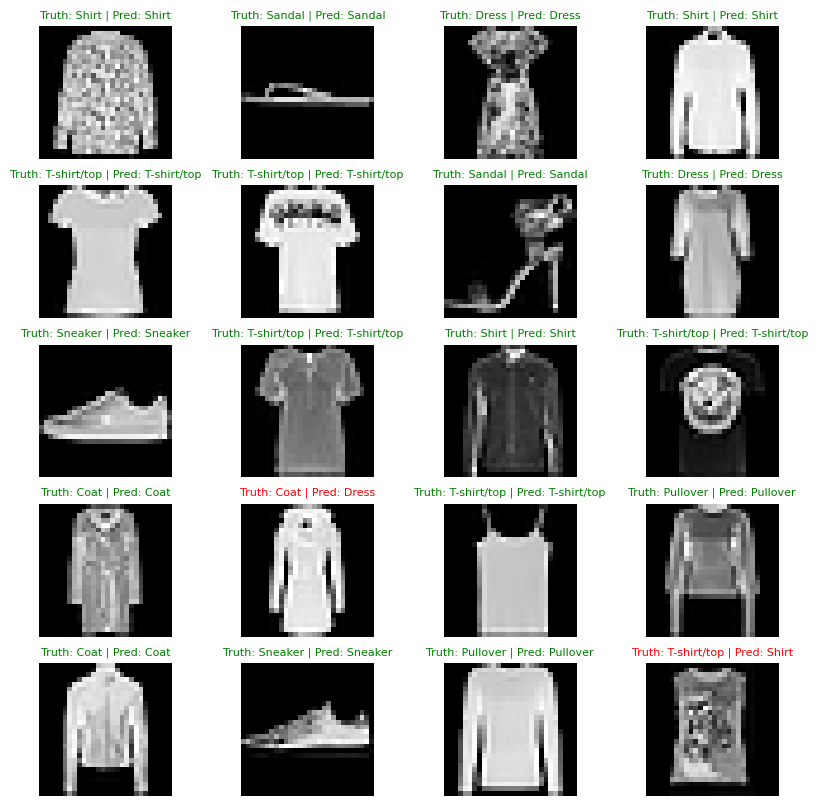

In [139]:
plt.figure(figsize=(10,10))
cols = 4
rows = len(test_samples) // cols
for i,sample in enumerate(test_samples):
    plt.subplot(rows,cols,i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    correct = test_labels[i] == pred_labels[i]
    color = "green" if correct else "red"
    plt.title(f"Truth: {classes[test_labels[i]]} | Pred: {classes[pred_labels[i]]}", fontsize=8, c=color)
    plt.axis(False)